In [1]:
import numpy as np
import pandas as pd
import os

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#读入数据
labels = pd.read_csv('../input/train.csv')
sub = pd.read_csv('../input/sample_submission.csv')
train_path = '../input/train/train/'
test_path = '../input/test/test/'

In [3]:
print('Num train samples:{0}'.format(len(os.listdir(train_path))))
print('Num test samples:{0}'.format(len(os.listdir(test_path))))

Num train samples:17500
Num test samples:4000


In [4]:
labels['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

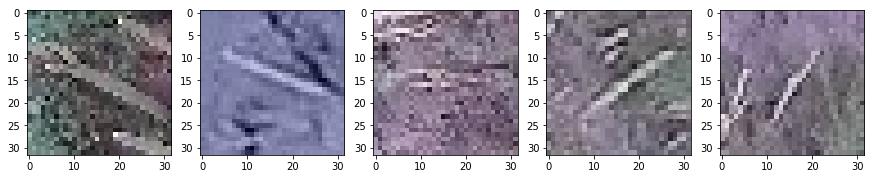

In [5]:
#展示一下标签为1的图片
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==1]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(cv2.imread(path))

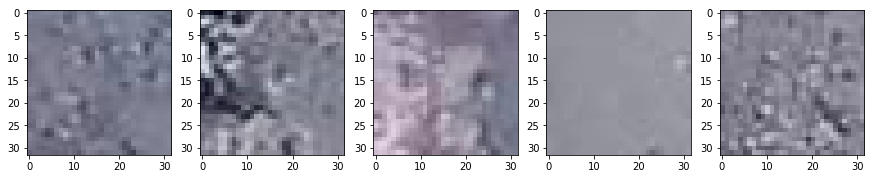

In [6]:
#展示一下标签为0的图片
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i, idx in enumerate(labels[labels['has_cactus']==0]['id'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(cv2.imread(path))

In [7]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

In [8]:
#定于超参数
num_epochs = 25
num_classes = 2
batch_size = 128
learning_rate = 0.002
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [9]:
train, val = train_test_split(labels, stratify=labels.has_cactus, test_size=0.1)
train.shape, val.shape

((15750, 2), (1750, 2))

In [10]:
#检查一下训练集和验证集的标签分布
train['has_cactus'].value_counts()

1    11822
0     3928
Name: has_cactus, dtype: int64

In [11]:
val['has_cactus'].value_counts()

1    1314
0     436
Name: has_cactus, dtype: int64

In [12]:
#定义数据生成器，通过继承Dataset类得到
class MyDataset(Dataset):
    def __init__(self, data, data_dir='./', transform=None):
        super().__init__()
        self.df = data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [13]:
# 图像预处理
trans_train = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

trans_valid = transforms.Compose([transforms.ToPILImage(),
                                  transforms.Pad(32, padding_mode='reflect'),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [14]:
dataset_train = MyDataset(data=train, data_dir=train_path, transform=trans_train)
dataset_valid = MyDataset(data=val, data_dir=train_path, transform=trans_valid)

loader_train = DataLoader(dataset = dataset_train, batch_size=batch_size, shuffle=True, num_workers=0)
loader_valid = DataLoader(dataset = dataset_valid, batch_size=batch_size//2, shuffle=False, num_workers=0)

In [15]:
#定义模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg = nn.AvgPool2d(4)
        self.fc = nn.Linear(512 * 1 * 1, 2) # !!!
   
    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)))) # first convolutional layer then batchnorm, then activation then pooling layer.
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(F.leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        x = x.view(-1, 512 * 1 * 1) 
        x = self.fc(x)
        return x

In [16]:
model = SimpleCNN().to(device)

In [17]:
# 损失和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [18]:
# 训练模型
total_step = len(loader_train)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(loader_train):
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/25], Step [100/124], Loss: 0.0348
Epoch [2/25], Step [100/124], Loss: 0.0407
Epoch [3/25], Step [100/124], Loss: 0.0211
Epoch [4/25], Step [100/124], Loss: 0.0190
Epoch [5/25], Step [100/124], Loss: 0.0376
Epoch [6/25], Step [100/124], Loss: 0.0204
Epoch [7/25], Step [100/124], Loss: 0.0459
Epoch [8/25], Step [100/124], Loss: 0.0085
Epoch [9/25], Step [100/124], Loss: 0.0066
Epoch [10/25], Step [100/124], Loss: 0.0078
Epoch [11/25], Step [100/124], Loss: 0.0060
Epoch [12/25], Step [100/124], Loss: 0.0044
Epoch [13/25], Step [100/124], Loss: 0.0042
Epoch [14/25], Step [100/124], Loss: 0.0031
Epoch [15/25], Step [100/124], Loss: 0.0006
Epoch [16/25], Step [100/124], Loss: 0.0047
Epoch [17/25], Step [100/124], Loss: 0.0024
Epoch [18/25], Step [100/124], Loss: 0.0014
Epoch [19/25], Step [100/124], Loss: 0.0002
Epoch [20/25], Step [100/124], Loss: 0.0005
Epoch [21/25], Step [100/124], Loss: 0.0001
Epoch [22/25], Step [100/124], Loss: 0.0001
Epoch [23/25], Step [100/124], Loss: 0.00

In [19]:
#用验证集评估模型
model.eval()  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loader_valid:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model on the 1750 validation images: {} %'.format(100 * correct / total))

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Test Accuracy of the model on the 1750 validation images: 99.88571428571429 %


In [20]:
# 生成测试数据
dataset_valid = MyDataset(data=sub, data_dir=test_path, transform=trans_valid)
loader_test = DataLoader(dataset = dataset_valid, batch_size=32, shuffle=False, num_workers=0)

In [21]:
model.eval()

preds = []
for batch_i, (data, target) in enumerate(loader_test):
    data, target = data.cuda(), target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

sub['has_cactus'] = preds
sub.to_csv('sub.csv', index=False)